# Transfer Learning of multi-label classification for dacon

In [2]:
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
from PIL import Image
from tensorflow.keras.datasets import mnist
from tqdm import tqdm_notebook
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas.util.testing as tm
import matplotlib.style as style

seed = 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


# 이미지 파일 만들기

* 타겟 불러오기

In [15]:
target = pd.read_csv('data/dirty_mnist_2nd_answer.csv',index_col='index')
target_names = target.columns

# 훈련데이터 정제

In [4]:
namelist = os.listdir('data/train_dirty_mnist_2nd/')

In [5]:

filepath = []
train_data = []


for i in tqdm_notebook(range(len(namelist))):
    filepath.append('data/train_dirty_mnist_2nd/' + namelist[i])
    train_data.append(imread('data/train_dirty_mnist_2nd/' + namelist[i], cv2.IMREAD_UNCHANGED))


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/50000 [00:00<?, ?it/s]

In [18]:
train_df = pd.DataFrame({'filepath':filepath, 'img':train_data})

In [27]:
train_df.to_csv('train_df.csv')

In [6]:
# 훈련데이터 np.array
#train_array = np.array(train_data)

# 훈련데이터 불러오기

In [28]:
train_df = pd.read_csv('train_df.csv', index_col=0)
train_df.head()

,filepath,img
0,data/train_dirty_mnist_2nd/00000.png,[[0.10196079 0.76862746 0.00392157 ... 0.29019...
1,data/train_dirty_mnist_2nd/00001.png,[[0.7058824 0. 0.09019608 ... 0.74117...
2,data/train_dirty_mnist_2nd/00002.png,[[0.9843137 0.01568628 0.44313726 ... 0.81568...
3,data/train_dirty_mnist_2nd/00003.png,[[0.34117648 0.14117648 0.03921569 ... 0.76862...
4,data/train_dirty_mnist_2nd/00004.png,[[0.32156864 0.30588236 0.52156866 ... 0.14509...


# 트레인 배열 저장 

In [9]:
np.savez('train_array',train_array = train_array)
train_array_saved = np.load('train_array.npz')
train_array_saved['train_array']

# 테스트데이터 정제

In [32]:
test_namelist = os.listdir('data/test_dirty_mnist_2nd/')

test_filepath = []
test_data = []


for i in tqdm_notebook(range(len(test_namelist))):
    test_filepath.append('data/test_dirty_mnist_2nd/' + test_namelist[i])
    test_data.append(imread('data/test_dirty_mnist_2nd/' + test_namelist[i], cv2.IMREAD_UNCHANGED))

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/5000 [00:00<?, ?it/s]

In [33]:
test_df = pd.DataFrame({'filepath':test_filepath, 'img':test_data})
test_df.to_csv('test_df.csv')

# 훈련데이터 불러오기

In [34]:
test_df = pd.read_csv('test_df.csv', index_col=0)
test_df.head()

,filepath,img
0,data/test_dirty_mnist_2nd/50000.png,[[0.5294118 0.00784314 0.07058824 ... 0.77254...
1,data/test_dirty_mnist_2nd/50001.png,[[0.41960785 0. 0.3529412 ... 0.81568...
2,data/test_dirty_mnist_2nd/50002.png,[[0.14509805 0.7529412 0.41568628 ... 0.79607...
3,data/test_dirty_mnist_2nd/50003.png,[[0.9254902 0.07843138 0.09019608 ... 0.72941...
4,data/test_dirty_mnist_2nd/50004.png,[[0.05098039 0.40392157 0.7882353 ... 0.30980...


# 훈련킷

In [25]:
IMG_SIZE = 128 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
# CHANNELS change by 1 from 3
N_LABELS = 26

In [26]:

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    #image_normalized = image_resized / 255.0
    return image_resized, label

In [35]:
BATCH_SIZE = 10 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [28]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# test 킷

In [14]:
def t_parse_function(filename):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    #######image_normalized = image_resized / 255.0 ########
    return image_resized

In [15]:
def t_create_dataset(filenames, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(t_parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# 트레인 과 검증 셋 분리

In [16]:
X_train = train_df['filepath'].values[:40000]
y_train_bin = target.values[:40000]

X_val = train_df['filepath'].values[40000:]
y_val_bin = target.values[40000:]

In [17]:
y_train_bin

array([[1, 1, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 0, 1]], dtype=int64)

In [36]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [37]:
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 26)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 128, 128, 3), (None, 26)), types: (tf.float32, tf.int64)>)

In [38]:
test_ds = t_create_dataset(test_df['filepath'].values)
onlytrain500_ds = t_create_dataset(train_df['filepath'][:500])

In [39]:
test_ds

<PrefetchDataset shapes: (None, 128, 128, 3), types: tf.float32>

In [40]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (10, 128, 128, 3)
Shape of labels array: (10, 26)


# 전이학습준비

In [88]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [89]:
# 훈련데이터세트가 원본데이터세트와(imagenet) 유사한 경우에만 True 권장
feature_extractor_layer.trainable = False

In [90]:
feature_extractor_layer

# 모델 쌓기 버전1

In [91]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 26)                26650     
Total params: 3,596,378
Trainable params: 1,338,394
Non-trainable params: 2,257,984
_________________________________________________________________


# 모델쌓기 버전2

In [20]:
module_selection = ("mobilenet_v1_100_128", 128)
handle_base, IMG_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/classification/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, (IMG_SIZE, IMG_SIZE)))

Using https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/classification/4 with input size (128, 128)


In [21]:
BATCH_SIZE = 256

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE) + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        #regularizers.l2(0.0001): 가중치 행렬의 모든 원소를 제곱하고 0.0001을 곱하여 네트워크의 전체 손실에 더해진다는 의미
        N_LABELS, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='sigmoid')
])
model.build((None,)+(IMG_SIZE, IMG_SIZE)+(3,))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              4254889   
_________________________________________________________________
dropout (Dropout)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                26052     
Total params: 4,280,941
Trainable params: 26,052
Non-trainable params: 4,254,889
_________________________________________________________________


# 직접 모델 쌓기

In [18]:
chanDim = 1

def smallvgg():
    model = Sequential()
    # 첫층은 패딩을 하지 않는다. 이미지데이터의 외각 픽셀이 정보를 포함하지않음
    model.add(Conv2D(32, (3, 3),activation = 'relu', input_shape=(256,256,1)))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    
    model.add(Conv2D(64, (3, 3), padding="same", activation = 'relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same",activation = 'relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Conv2D(64, (3, 3), padding="same",activation = 'relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same",activation = 'relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())
    model.add(Dense(512 ,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(26, activation = 'sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='binary_crossentropy',
        metrics=[macro_f1])
    
    return model

# vgg16 훈련

In [1]:
from tensorflow.keras.applications import ResNet50

In [2]:
resnet50 = ResNet50(include_top=False, weights='imagenet')

94773248/94765736 [==============================] - 2s 0us/step


In [41]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [42]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

import keras.backend.tensorflow_backend as K

resnet50 = ResNet50(include_top=False, weights='imagenet')
bottleneck_features_train = resnet50.predict(train_ds)
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_validation = resnet50.predict(val_ds)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))

#Simple sequential model 
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(26, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=validation_data)

model.save_weights(top_model_weights_path)

ResourceExhaustedError:  OOM when allocating tensor with shape[10,256,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node resnet50/conv2_block3_3_bn/FusedBatchNormV3 (defined at <ipython-input-42-0d129862ea85>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_21655]

Function call stack:
predict_function


In [26]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [25]:
40000 * 7 * 7 * 512

1003520000

# 모델생성

In [24]:
model = smallvgg()

# 모델 요약

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 32)      1024      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 85, 85, 64)        340       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)       

# cost function 함수

In [93]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

# 정확도 분석함수

In [94]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

# 컴파일 (비용함수 적용)

In [95]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [96]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

# callback 함수 

In [97]:
MODEL_DIR = './Mnistmodel/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './Mnistmodel/Mnist_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                              verbose=1, save_best_only=True)

stop = EarlyStopping(patience=10)

callbacks = [stop, checkpointer]

# 모델 훈련

In [98]:
history = model.fit(train_ds,
  epochs=EPOCHS,
  validation_data=create_dataset(X_val, y_val_bin),
  callbacks = callbacks)

Epoch 1/30
157/157 [==============================] - 79s 449ms/step - loss: 0.4517 - macro_f1: 0.5577 - val_loss: 0.3842 - val_macro_f1: 0.6308

Epoch 00001: val_loss improved from inf to 0.38423, saving model to ./Mnistmodel\Mnist_01-0.3842.hdf5
Epoch 2/30
157/157 [==============================] - 127s 813ms/step - loss: 0.3803 - macro_f1: 0.6309 - val_loss: 0.3738 - val_macro_f1: 0.6308

Epoch 00002: val_loss improved from 0.38423 to 0.37380, saving model to ./Mnistmodel\Mnist_02-0.3738.hdf5
Epoch 3/30
157/157 [==============================] - 115s 732ms/step - loss: 0.3731 - macro_f1: 0.6308 - val_loss: 0.3711 - val_macro_f1: 0.6306

Epoch 00003: val_loss improved from 0.37380 to 0.37113, saving model to ./Mnistmodel\Mnist_03-0.3711.hdf5
Epoch 4/30
157/157 [==============================] - 115s 729ms/step - loss: 0.3709 - macro_f1: 0.6309 - val_loss: 0.3702 - val_macro_f1: 0.6309

Epoch 00004: val_loss improved from 0.37113 to 0.37024, saving model to ./Mnistmodel\Mnist_04-0.370

# 그래프

In [73]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

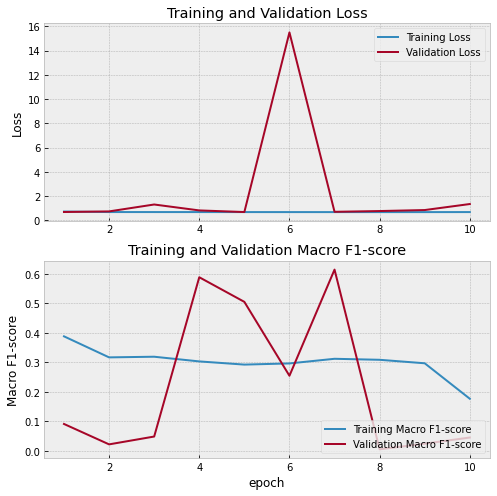

([0.7336959838867188,
  0.6925248503684998,
  0.6914722919464111,
  0.6910462379455566,
  0.6904411911964417,
  0.6894186735153198,
  0.6885760426521301,
  0.6881418228149414,
  0.6878610253334045,
  0.6909964680671692],
 [0.6958025097846985,
  0.7459895610809326,
  1.3147220611572266,
  0.8266924619674683,
  0.6942086219787598,
  15.493017196655273,
  0.7124137878417969,
  0.7756255865097046,
  0.857327938079834,
  1.3536659479141235],
 [0.38813599944114685,
  0.3168281614780426,
  0.3190267086029053,
  0.3031316101551056,
  0.29234397411346436,
  0.2963313162326813,
  0.3120395541191101,
  0.30862048268318176,
  0.2968140244483948,
  0.17656391859054565],
 [0.09111028164625168,
  0.02194293402135372,
  0.04847866669297218,
  0.5884721875190735,
  0.5050005316734314,
  0.2544856369495392,
  0.6143304705619812,
  0.005172623321413994,
  0.024225300177931786,
  0.04515866935253143])

In [74]:
learning_curves(history)

# 예측값

In [102]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

# 이미지와 예측값

,filepath,img
0,data/train_dirty_mnist_2nd/00000.png,[[0.10196079 0.76862746 0.00392157 ... 0.29019...
1,data/train_dirty_mnist_2nd/00001.png,[[0.7058824 0. 0.09019608 ... 0.74117...
2,data/train_dirty_mnist_2nd/00002.png,[[0.9843137 0.01568628 0.44313726 ... 0.81568...
3,data/train_dirty_mnist_2nd/00003.png,[[0.34117648 0.14117648 0.03921569 ... 0.76862...
4,data/train_dirty_mnist_2nd/00004.png,[[0.32156864 0.30588236 0.52156866 ... 0.14509...
...,...,...
49995,data/train_dirty_mnist_2nd/49995.png,[[0.23529412 0.85882354 0.15686275 ... 0.43529...
49996,data/train_dirty_mnist_2nd/49996.png,[[0.18039216 0.07058824 0.77254903 ... 0.74901...
49997,data/train_dirty_mnist_2nd/49997.png,[[0.9411765 0.6784314 0.5529412 ... 0.53333...
49998,data/train_dirty_mnist_2nd/49998.png,[[0.88235295 0.63529414 0.01960784 ... 0.52941...


In [2]:
path = 'data/test_dirty_mnist_2nd/50000.png'

In [4]:
img = imread(path)

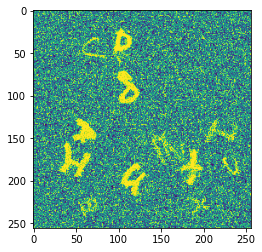

In [5]:
plt.imshow(img)

In [13]:
import numpy as np 
import cv2 

img = cv2.imread(path) 

b, g, r = cv2.split(img) 

def showImage(window, img): 
    cv2.namedWindow(window, cv2.WINDOW_NORMAL) 
    cv2.imshow(window, img) 
    showImage("original", img) 
    
showImage("b", b) 
showImage("g", g) 
showImage("r", r) 

cv2.waitKey(0) 
cv2.destroyAllWindows()



RecursionError: maximum recursion depth exceeded while calling a Python object

In [9]:
img.shape

(256, 256)

In [118]:
train_df['filepath'][0].split('2nd/')[1][:5]

'00000'

In [131]:
img_path

'data/train_dirty_mnist_2nd/00000.png'

In [127]:
img_path = train_df['filepath'][0]

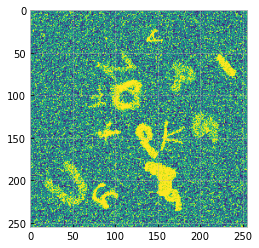

In [130]:
plt.imshow(Image.open(img_path))

In [140]:
train_df.head()

,filepath,img
0,data/train_dirty_mnist_2nd/00000.png,[[0.10196079 0.76862746 0.00392157 ... 0.29019...
1,data/train_dirty_mnist_2nd/00001.png,[[0.7058824 0. 0.09019608 ... 0.74117...
2,data/train_dirty_mnist_2nd/00002.png,[[0.9843137 0.01568628 0.44313726 ... 0.81568...
3,data/train_dirty_mnist_2nd/00003.png,[[0.34117648 0.14117648 0.03921569 ... 0.76862...
4,data/train_dirty_mnist_2nd/00004.png,[[0.32156864 0.30588236 0.52156866 ... 0.14509...


In [149]:
target.iloc[:1]

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,1,1


In [141]:
target

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,1,1
1,1,0,0,1,0,1,0,1,0,1,...,0,1,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,1,1,...,0,0,1,1,1,0,1,1,1,0
3,0,0,1,0,0,0,1,1,0,0,...,1,0,1,1,0,1,1,0,1,0
4,0,1,0,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
49996,0,1,0,1,0,1,1,1,0,1,...,0,1,1,1,0,1,0,0,0,1
49997,0,1,0,0,1,1,1,1,0,0,...,1,0,0,0,0,1,1,1,0,0


In [137]:
from keras.preprocessing import image

Using TensorFlow backend.


In [152]:
def show_prediction(filename, train_df, model):
    realnums = target
    img_path = filename
    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = target_names
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\n\nPrediction\n{}\n'.format(filename,list(prediction)), fontsize=9)
    plt.show()

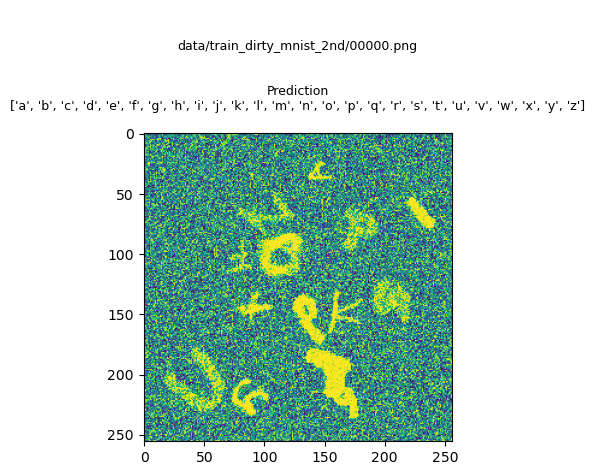

In [153]:
show_prediction('data/train_dirty_mnist_2nd/00000.png',train_df,model)

In [107]:
len(target.values)

50000

In [108]:
label_names = target_names

grid = perf_grid(val_ds, y_val_bin, label_names, model )

In [112]:
import seaborn as sns

In [113]:
max_perf = grid.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,7,h,0.470000,0.641212
1,23,x,0.470000,0.641027
2,19,t,0.470000,0.640381
3,1,b,0.470000,0.638066
4,9,j,0.470000,0.637324
5,2,c,0.470000,0.636488
6,18,s,0.460000,0.634626
7,11,l,0.460000,0.634253
8,25,z,0.460000,0.632946
9,6,g,0.460000,0.631824


In [65]:
prediction = model.predict(onlytrain500_ds)

In [66]:
prediction[0]

array([0.99999785, 0.9999957 , 0.9999976 , 0.9999975 , 0.9999974 ,
       0.999998  , 0.9999976 , 0.9999975 , 0.9999988 , 0.99999666,
       0.9999974 , 0.9999976 , 0.9999976 , 0.9999958 , 0.9999962 ,
       0.99999833, 0.999997  , 0.9999943 , 0.9999956 , 0.9999956 ,
       0.99999666, 0.999997  , 0.99999785, 0.9999958 , 0.9999974 ,
       0.99999714], dtype=float32)

In [48]:
classification = []

for i in prediction[0]:
    if i > np.mean(prediction[0]):
        classification.append(1)
    else:
        classification.append(0)
    

In [49]:
classification

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]

In [50]:
print(y_train_bin[0])

[1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1]


In [51]:
recall = 0
precision = 0

for i in range(len(classification)):
    if classification[i] == y_train_bin[0][i]:
        precision +=1
        if classification[i] == 1:
            recall += 1


print('맞은 개수는:{}'.format(precision))
print('정확한 정답을 맞춘 갯수는{}'.format(recall))

맞은 개수는:12
정확한 정답을 맞춘 갯수는3


In [43]:
collect

11

# 모델저장

In [49]:
model.save_weights('mobilenet_v2.h5')

In [48]:
with open('mnist_architecture.json','w') as fp:
    fp.write(model.to_json(indent='\t'))

# 모델 요약

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              4254889   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1026048   
_________________________________________________________________
output (Dense)               (None, 26)                26650     
Total params: 5,307,587
Trainable params: 1,052,698
Non-trainable params: 4,254,889
_________________________________________________________________


# 모델 불러오기

In [51]:
model.load_weights('mobilenet_v2.h5')

In [50]:
from keras.models import model_from_json

with open('mnist_architecture.json','r') as fp:
    model = model_from_json(fp.read())
    
model.load_weights('mobilenet_v2.h5')

TypeError: __init__() got an unexpected keyword argument 'ragged'

In [44]:
load_status = model.load_weights('mobilenet_v2.h5')

In [46]:
type(load_status)

NoneType

# 그래프..

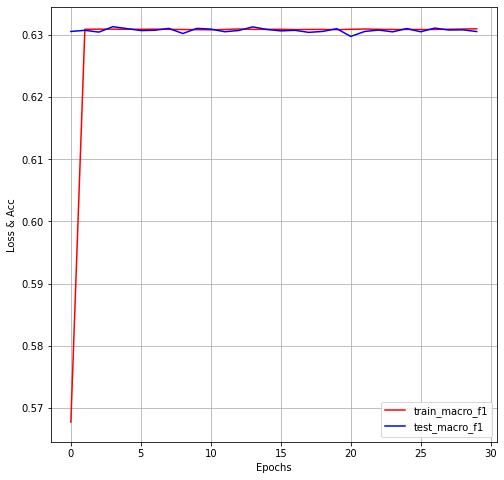

In [38]:
train_f1_score = history.history['macro_f1']
test_f1_score = history.history['val_macro_f1']

plt.figure(figsize=(8,8))
x_len = np.arange(len(train_accuracy))

plt.plot(x_len,train_f1_score, c = 'red', label = 'train_macro_f1')
plt.plot(x_len, test_f1_score , c = 'blue', label = 'test_macro_f1')
plt.legend(loc = 'best')

plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss & Acc")
plt.show()

# 테스트 데이터 정제

In [32]:
prediction = model.predict(test_ds)
prediction_train = model.predict(onlytrain500_ds)

In [58]:
len(X_val), len(y_val_bin)

(10000, 10000)

In [33]:
prediction

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [64]:
model.evaluate(train_ds)

157/157 [==============================] - 84s 533ms/step - loss: 0.3691 - macro_f1: 0.6309


[0.3691053092479706, 0.6308845281600952]

In [63]:
len(y_train_bin), len(X_train)

(40000, 40000)

In [73]:
prediction_train

array([[0.9999676 , 0.9999634 , 0.99997985, ..., 0.9999645 , 0.9999877 ,
        0.9999732 ],
       [0.99997485, 0.99997675, 0.9999807 , ..., 0.9999752 , 0.9999881 ,
        0.9999715 ],
       [0.9999809 , 0.9999807 , 0.99998593, ..., 0.999982  , 0.99999106,
        0.9999831 ],
       ...,
       [0.99997973, 0.9999714 , 0.9999858 , ..., 0.9999726 , 0.9999881 ,
        0.9999733 ],
       [0.99997056, 0.99995637, 0.9999819 , ..., 0.9999552 , 0.9999808 ,
        0.9999709 ],
       [0.9999577 , 0.9999517 , 0.99997175, ..., 0.9999565 , 0.9999814 ,
        0.99995863]], dtype=float32)

In [101]:
test_ds.take(1)

<TakeDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0

In [45]:
path

'data/test_dirty_mnist_2nd/50000.png'

In [46]:
image_string = tf.io.read_file(path)

In [53]:
image_decoded = tf.image.decode_jpeg(image_string, channels=1)

In [54]:
image_decoded

<tf.Tensor: shape=(256, 256, 1), dtype=uint8, numpy=
array([[[135],
        [  2],
        [ 18],
        ...,
        [197],
        [126],
        [100]],

       [[222],
        [ 73],
        [129],
        ...,
        [ 66],
        [104],
        [ 26]],

       [[135],
        [ 72],
        [161],
        ...,
        [130],
        [134],
        [223]],

       ...,

       [[ 20],
        [122],
        [234],
        ...,
        [191],
        [ 88],
        [151]],

       [[192],
        [236],
        [222],
        ...,
        [138],
        [ 85],
        [ 86]],

       [[234],
        [196],
        [148],
        ...,
        [165],
        [219],
        [163]]], dtype=uint8)>